# Libraries & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import psycopg2

# settings
datapath = '/Users/mirkoknoche/MIMIC/'
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,}'.format
%matplotlib inline

# database
conn_string = open('./intern/DB_connection.txt', 'r', encoding='UTF-8').read()

# Selecting Patient Group

We filter the patients in three steps.   
+ First we select from all admissions those who are **diagnosed with ARDS**:    
We find the diagnoses in the table DIAGNOSES_ICD. All diagnoses for each HADM_ID are listed there.    
ARDS is the abbreviation for "Acute Respiratory Distress Syndrome" and means a syndrome with multiple risk 
factors that trigger the acute onset of respiratory insufficiency.   
The ICD9 Code for ARDS is **51881**. So we select all HADM_IDs for which the number 51881  appeared in 
table DDIAGNOSES_ICD in column ICD9_CODE. We find 7497 unique HADM_ID with diagnosis ARDS.   
Because newborns with respiratory failure are diagnosed with ICD9 Code 769 
("Respiratory distress syndrome in newborn"), there is no need to separate the adults from the babies.
+ Then we examine which of these ARDS patients were **ventilated**. To do this, we check the table CPT_EVENTS 
(billing for procedures performed on patients) to see whether ventilation has been invoiced. 
We take into account the CPT (current procedural terminology =CPT) Codes 94003 and 94002. 
These numbers mean ventilation management.   
There are two other codes that deal with ventilation (94004 and 94660). But neither appear in this data.   
To be sure we can find all ventilated ARDS patients, we continue to review evidence of invasive ventilation.  
We look in the table PROCEDURES_ICD for the numbers 9672, 9671, 9670 in the column ICD9_Code. 
These numbers mean "Continuous invasive mechanical ventilation for 96 consecutive hours or more",
 "Continuous invasive mechanical ventilation for less then 96 consecutive hours", "Continuous invasive mechanical 
 ventilation of unspecified duration".      
We also look in the table PROCEDUREEVENTS_MV for the number 225792 in the column ITEMID.
This number means "Invasive Ventilation".   
We also look in the table DRGCODES for the numbers 1303, 475, 566, 576, 208 in the column DRG_CODE.
These numbers mean "Respiratory System Diagnosis with Ventilator Support".  
+ In the next step we exclude those patients who have never been extubated. These patients
 died before extubation or we cannot see the extubation or they were moved to another ICU . This are 778.


We find a total of 5897 HADM_IDs who met these criteria. They are saved in the file selection_hadm.



# Selecting Features

|Feature|Table|Column|Parameter|Matched on|Comment
|:-----------|:-----------|:---------|:--------------|:----------------|:-------------|
|**Demographics**| | | | | |.     
|Subject_ID|ADMISSIONS|SUBJECT_ID| | HADM_ID|               |   
|Gender|PATIENTS|GENDER| |SUBJECT_ID |    
|Age|PATIENTS| DOB| |SUBJECT_ID| Shifted Dates:  Calculate DOB - ADMITTIME| |  
|**Clinical**|  
|Number of Diagnoses|DIAGNOSES_ICD|SEQ_NUM||HADM_ID| Take the maximum|  
|Length of stay|ICU_STAYS|LOS| |HADM_ID |  |  
|ICU|ICU_STAYS|LAST_CAREUNIT| | HADM_ID| |  
|Tracheostomy|DRGCODES|DRG_CODE|44, 54 | HADM_ID|  |   
|**Bedside Signs** | 
|Heart Rate|CHARTEVENTS|ITEM_ID|211, 220045|HADM_ID|   
|Blood Pressure|CHARTEVENTS|ITEM_ID|52, 456, 225312, 220181, 220052| HADM_ID|  
|Temperatur|CHARTEVENTS|ITEM_ID|676, 677,223762|HADM_ID||
|O<sub>2</sub>  Saturation|CHARTEVENTS|ITEM_ID|646, 834, 22077, 22027|HADM_ID|  
|**Ventilator Set**|  
|Breath Rate| CHARTEVENTS|ITEM_ID|618, 220210, 224688|HADM_ID| |  
|Breath-Minute-Volume|	CHARTEVENTS	|ITEM_ID|	445, 448, 449, 224687, 1340, 1486, 1600| HADM_ID|  |
|FiO<sub>2</sub>|CHARTEVENTS|ITEM_ID| 189, 190, 3420, 3422, 223835| HADM_ID||
|Tidal Volume| CHARTEVENTS|ITEM_ID|681, 682, 683, 684, 224685, 224686, 224684    |HADM_ID| |   
|Mean Insp. Pressure| CHARTEVENTS|ITEM_ID|444, 224697|HADM_ID| |   
|PEEP|CHARTEVENTS|ITEM_ID|506, 224695|HADM_ID| |   
|**Blood Signs**|  
|PaO2|LABEVENTS|ITEM_ID|50821|HADM_ID| |   
|Base Excess|LABEVENTS|ITEM_ID|50802|HADM_ID| |   
|pH|LABEVENTS|ITEM_ID|50820|HADM_ID| |   
|Hemoglobin|LABEVENTS|ITEM_ID|51222|HADM_ID| |   
|Hematocrit|LABEVENTS|ITEM_ID|51221|HADM_ID| |   
|Kreatinin|LABEVENTS|ITEM_ID|50912|HADM_ID| |   
|Leukocytes (WBC)|CHARTEVENTS|ITEM_ID|1127, 861, 1542|HADM_ID| |   
|Lactic Acid|CHARTEVENTS|ITEM_ID|225668, 1531, 818|HADM_ID| |    



We select the measurement from the vital and blood values ​​that is closest to the time of extubation.

# Define Label

We investigate the success of an extubation.  
Failed (0) = Re-intubated within 48 hours extubation.  
Succeeded (1) =  Remains extubated 48 hours after extubation

Direct information of whether the patient is on or off the ventilator at any given time is not available in MIMIC. To infer ventilation status, we used a heuristic approach, empirically utilizing information from multiple chart variables that were informative of ventilation status:
 
Ventilator Mode, Minute Volume, Respiratory Pressure, Inspir. Pressure, Respiratory Support, Plateau Pressure, APRV pressure, PEEP, High Pressure Relief, PVC, TCPCV, PSVlevel and Oxygen Delivery Device.     
Ventilation status was coded as "MechVent" or "OxygenTherapy". The initiation of oxygen therapy indicates the ventilation has ended. An "extubation" event was defined as the time point where "MechVent" status changed from 1 to 0 and "OxygenTherapy" status changed from 0 to 1.   
Some patients whose data was recorded with carvue have the entry "Extubated" in the "Significant Events" section. This gives us the opportunity to check our determination of the time of extubation. 

## Time Point of Extubation

Here, we would like to examine if there is a specific entry for "extubation" in the dataset. In the database we have found columnnames that may tell us something about the extubation time point: *mechvent*, *oxygentherapy*, *extubated*, *selfextubated*. 

In [2]:
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [3]:
sql = """select i2.hadm_id, v.* 
        from ventsettings v
        inner join icustays i2 on i2.icustay_id = v.icustay_id 
        where (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0
        order by icustay_id, charttime """
df = pd.read_sql(sql, conn)

In [4]:
df.shape

(592908, 7)

In [5]:
df.head(3)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592908 entries, 0 to 592907
Data columns (total 7 columns):
hadm_id          592908 non-null int64
icustay_id       592908 non-null float64
charttime        592908 non-null datetime64[ns]
mechvent         592908 non-null int64
oxygentherapy    592908 non-null int64
extubated        592908 non-null int64
selfextubated    592908 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 31.7 MB


In [7]:
df_count_ex = df.groupby('icustay_id').extubated.sum()

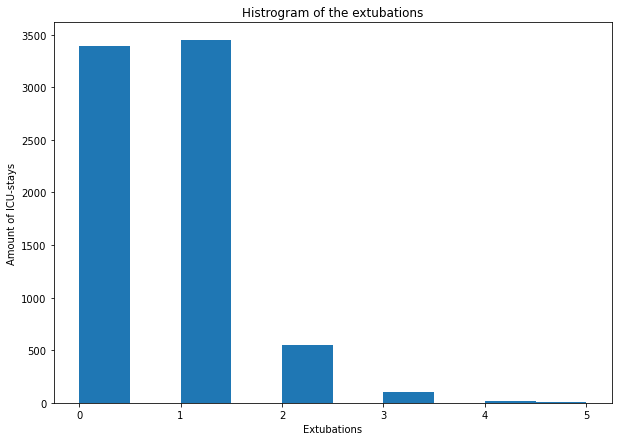

In [8]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_count_ex)
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Histrogram of the extubations')
plt.savefig('./images/hist_extubations_per_icustay.png')
plt.show();

Many patients (icu stay ID's) have no explicit documented extubation. Thus, we will look further to gather more information. 

In [9]:
err_ext = list(df_count_ex[df_count_ex == 0].index)
len(err_ext)

3391

In [10]:
sql = """select * from transfers"""
df_icuunit = pd.read_sql(sql, conn)

# Filtering the icustay_id's with no extubations
df_icuunit = df_icuunit[df_icuunit.icustay_id.isin(err_ext)]

# use only the interesting columns
df_icuunit = df_icuunit[['icustay_id', 'curr_careunit']]

# drop duplicates
df_icuunit.drop_duplicates(inplace=True)

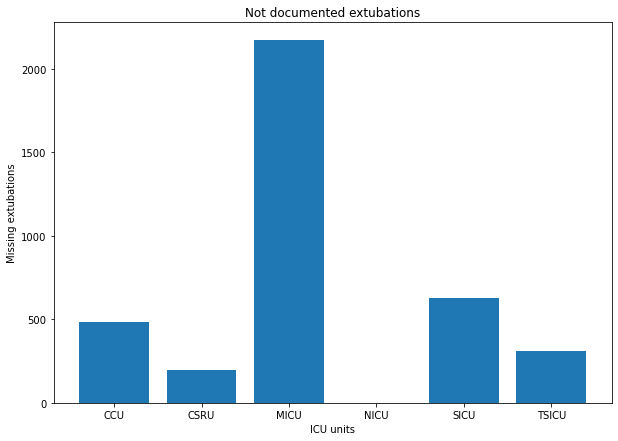

In [11]:
df_plot = df_icuunit.groupby('curr_careunit').count()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.bar(list(df_plot.index), height=list(df_plot.values.flatten()))
plt.ylabel('Missing extubations')
plt.xlabel('ICU units')
plt.title('Not documented extubations')
plt.savefig('./images/missing_extubations_per_unit.png')
plt.show();

##### Inspect one patient

In [12]:
df_qry = df[df.icustay_id == 200063]
df_qry.head()

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
116,129142,"200,063.0",2141-03-10 07:00:00,1,0,0,0
117,129142,"200,063.0",2141-03-10 08:00:00,1,0,0,0
118,129142,"200,063.0",2141-03-10 09:00:00,1,0,0,0
119,129142,"200,063.0",2141-03-10 09:11:00,1,0,0,0
120,129142,"200,063.0",2141-03-10 13:00:00,1,0,0,0


In [13]:
# getting the changes
df_qry['extube'] = df_qry['mechvent'].diff()
df_qry['oxy'] = df_qry['oxygentherapy'].diff()

In [14]:
df_qry.extube.fillna(0, inplace=True)
df_qry.oxy.fillna(0, inplace=True)

In [15]:
df_qry.loc[160:180]

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,extube,oxy
160,129142,"200,063.0",2141-03-15 00:00:00,1,0,0,0,0.0,0.0
161,129142,"200,063.0",2141-03-15 03:00:00,1,0,0,0,0.0,0.0
162,129142,"200,063.0",2141-03-15 06:00:00,1,0,0,0,0.0,0.0
163,129142,"200,063.0",2141-03-15 07:00:00,1,0,0,0,0.0,0.0
164,129142,"200,063.0",2141-03-15 09:15:00,1,0,0,0,0.0,0.0
165,129142,"200,063.0",2141-03-15 10:00:00,1,0,0,0,0.0,0.0
166,129142,"200,063.0",2141-03-15 11:50:00,1,0,0,0,0.0,0.0
167,129142,"200,063.0",2141-03-15 12:00:00,1,0,0,0,0.0,0.0
168,129142,"200,063.0",2141-03-15 13:00:00,1,0,0,0,0.0,0.0
169,129142,"200,063.0",2141-03-15 14:09:00,0,0,1,0,-1.0,0.0


In [16]:
df_qry[(df_qry['extube'] != 0) | (df_qry['oxy'] != 0)]

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,extube,oxy
169,129142,"200,063.0",2141-03-15 14:09:00,0,0,1,0,-1.0,0.0
170,129142,"200,063.0",2141-03-15 14:10:00,0,1,0,0,0.0,1.0
177,129142,"200,063.0",2141-03-16 09:00:00,1,0,0,0,1.0,-1.0
193,129142,"200,063.0",2141-03-18 13:00:00,0,0,1,0,-1.0,0.0
194,129142,"200,063.0",2141-03-18 17:55:00,0,1,0,0,0.0,1.0
195,129142,"200,063.0",2141-03-21 10:00:00,1,0,0,0,1.0,-1.0
226,129142,"200,063.0",2141-03-24 16:31:00,0,1,0,0,-1.0,1.0
227,129142,"200,063.0",2141-03-24 17:30:00,0,0,1,0,0.0,-1.0
228,129142,"200,063.0",2141-03-24 20:00:00,0,1,0,0,0.0,1.0
261,129142,"200,063.0",2141-03-31 11:21:00,1,0,0,0,1.0,-1.0


##### The few extubation entries we were able to find are extracted and labeled with 0 and 1. 

In [19]:
# Was an extubation successful? 1 = Yes, 0 = No
"""select vel.hadm_id, vel."label" 
from vw_extubation_label vel """


'select vel.hadm_id, vel."label" \nfrom vw_extubation_label vel '

In the database we have build an dataframe *vw_timestamp_extubation* that contains the time point of the last extubation for each admission ID. 

In [ ]:
# Timestamp of extubation
select hadm_id, charttime 
from vw_timestamp_extubation vte

In [ ]:
# Timestamp of first extubation
select hadm_id, min(charttime)
from vw_timestamp_extubation vte
group by hadm_id 
order by hadm_id 